In [1]:
import pandas as pd

from eval_lib import load_model
from models import Transformer
from matplotlib import pyplot as plt
import numpy as np
import torch
from data_handling import data_loader
import utils
import pprint
from trainer_lib.datasets import TimeSeriesWindowedTensorDataset, TimeSeriesWindowedDatasetConfig
from signal_decomposition import eemd, wavelet

params, model, _ = load_model(test='regular', name='Alert_Bunny', epoch=10, model_type=Transformer)

print(params)

{'src_size': 1, 'tgt_size': 1, 'd_model': 256, 'num_heads': 2, 'num_layers': 2, 'd_ff': 1024, 'src_seq_length': 24, 'tgt_seq_length': 1, 'src_window': 8, 'tgt_window': 1, 'dropout': 0}


In [2]:
df = data_loader.load_mavir_data('data/mavir_data/mavir.csv')
df['Power'] = utils.min_max_norm(df['Power'])
sample = utils.sample(df, 1000, start_idx=10000)
data = np.array(sample['Power'].to_numpy()[..., np.newaxis], dtype=np.float32)

In [3]:
dataset = TimeSeriesWindowedTensorDataset(data, 
                                          TimeSeriesWindowedDatasetConfig(params['src_window'], 
                                          params['tgt_window'], 
                                          params['src_seq_length'], 
                                          params['tgt_seq_length'], 1, False))

torch.Size([192, 1]) torch.Size([1, 1])


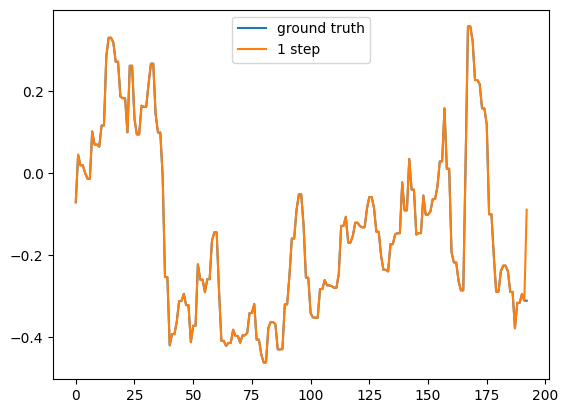

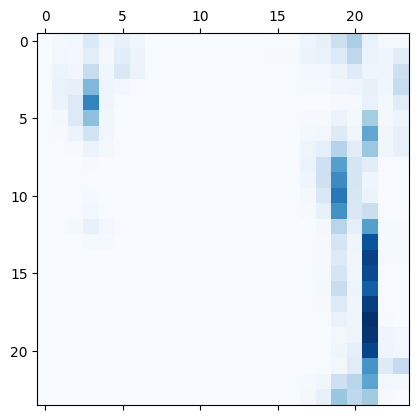

In [4]:
shift, look_back, pred = 499, 24, 1

ones = torch.ones(1, 1, dataset[0][1].shape[-1])

out = ones
print(dataset.get_sequence_from_x_windows(dataset[shift][0].unsqueeze(0)).shape, dataset.get_sequence_from_y_windows(dataset[shift][1].unsqueeze(0)).shape)
gt = torch.concat([dataset.get_sequence_from_x_windows(dataset[shift][0].unsqueeze(0)), 
                   dataset.get_sequence_from_y_windows(dataset[shift][1].unsqueeze(0))])
for i in range(pred - 1):
    out = torch.concatenate((ones, model(dataset[shift][0].unsqueeze(0), out)), dim=1)

out, enc_attn, dec_self_attn, dec_cross_attn = model(dataset[shift][0].unsqueeze(0), out, True)

output = torch.concat([dataset.get_sequence_from_x_windows(dataset[shift][0].unsqueeze(0)), 
                       dataset.get_sequence_from_y_windows(out.detach())])
    
plt.plot(gt.reshape(dataset.sl_x * dataset.ws_x + dataset.sl_y) * dataset.ws_y, label='ground truth')
plt.plot(output.reshape(dataset.sl_x * dataset.ws_x + dataset.sl_y * dataset.ws_y), label=f'{pred} step')            
plt.legend()
plt.show()

plt.matshow(enc_attn[0].detach().numpy()[0, 0, :, :], cmap=plt.cm.Blues)